# Домашнее задание: Обучение и визуализация Mamba

Цель задания

Обучить простую модель семейства Mamba для обработки любых данных (на выбор: текст, аудио, видео, изображения и ...)
Визуализировать веса внимания и интерпретировать их
Сделать выводы о том, как модель воспринимает данные и принимает решения

In [11]:
! pip install torch torchvision torchaudio datasets tqdm --quiet

In [20]:
import math, re, random, collections
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = "cpu"
SEED = 42
BATCH_SIZE = 64
LR = 3e-4
EMB_DIM = 128
STATE_DIM = 64
MAX_LEN = 128
random.seed(SEED)
torch.manual_seed(SEED)

In [21]:
RAW_TRAIN = load_dataset("ag_news", split="train[:5000]")
RAW_TEST = load_dataset("ag_news", split="test[:1000]")


def basic_tokenizer(text):
    # простейшая токенизация: слова и цифры
    return re.findall(r"[A-Za-z]+|[0-9]+", text.lower())


# строим словарь
counter = collections.Counter(tok for ex in RAW_TRAIN["text"]
                              for tok in basic_tokenizer(ex))
itos = ["<pad>", "<unk>"] + [t for t, c in counter.items() if c >= 3]
stoi = {t: i for i, t in enumerate(itos)}


def encode(text):
    return [stoi.get(tok, stoi["<unk>"]) for tok in basic_tokenizer(text)][:MAX_LEN]


class NewsDataset(Dataset):
    def __init__(self, ds):
        self.data = [(encode(t), l) for t, l in zip(ds["text"], ds["label"])]

    def __len__(self): return len(self.data)

    def __getitem__(self, idx): return self.data[idx]


def collate(batch):
    seqs, labels = zip(*batch)
    l = [len(s) for s in seqs]
    padded = [s + [0] * (MAX_LEN - len(s)) for s in seqs]
    return torch.tensor(padded, dtype=torch.long), torch.tensor(labels)


train_loader = DataLoader(NewsDataset(RAW_TRAIN), BATCH_SIZE,
                          shuffle=True, collate_fn=collate)
test_loader = DataLoader(NewsDataset(RAW_TEST), BATCH_SIZE,
                         shuffle=False, collate_fn=collate)

print(f"Vocab size: {len(itos)}")

Vocab size: 7230


In [22]:
class SimpleMambaBlock(nn.Module):
    def __init__(self, d_model, d_state):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.in_proj = nn.Linear(d_model, d_state * 2)
        self.w = nn.Parameter(torch.randn(d_state))  # затухание
        self.out_proj = nn.Linear(d_state, d_model)

    def forward(self, x, return_gates=False):
        h = self.norm(x)
        u, v = self.in_proj(h).chunk(2, dim=-1)  # [B,L,S] each
        sigma_w = torch.sigmoid(self.w)  # [S]
        s = torch.zeros(x.size(0), STATE_DIM, device=x.device)
        outs, gates = [], []
        for t in range(x.size(1)):
            s = s * sigma_w + u[:, t]  # обновили скрытое состояние
            g = torch.sigmoid(v[:, t])  # gate-вектор размер S
            gates.append(g.detach())  # для визуализации
            outs.append(self.out_proj(s * g))
        y = torch.stack(outs, dim=1)  # [B,L,D]
        if return_gates:
            return x + y, torch.stack(gates, dim=1)
        return x + y


In [23]:
class MambaClassifier(nn.Module):
    def __init__(self, vocab, num_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab, EMB_DIM)
        self.pos = nn.Parameter(torch.randn(MAX_LEN, EMB_DIM))
        self.m1 = SimpleMambaBlock(EMB_DIM, STATE_DIM)
        self.m2 = SimpleMambaBlock(EMB_DIM, STATE_DIM)
        self.head = nn.Linear(EMB_DIM, num_classes)

    def forward(self, x, return_gates=False):
        h = self.emb(x) + self.pos[:x.size(1)]
        h, g1 = self.m1(h, return_gates=True)  # берём g1 для визуализации
        h = self.m2(h)
        # сферическое усреднение по токенам
        h = h.mean(dim=1)
        if return_gates:
            return self.head(h), g1  # [B,C] , [B,L,S]
        return self.head(h)


model = MambaClassifier(len(itos), 4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
print("Параметров всего:", sum(p.numel() for p in model.parameters()) // 1_000, "K")

Параметров всего: 992 K


In [25]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    model.train();
    total = correct = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad();
        loss.backward();
        optimizer.step()
        total += y.size(0)
        correct += (logits.argmax(-1) == y).sum().item()
    print(f"Epoch {epoch}")
    print(f"  train acc: {correct / total:.3f}")
    # простая валидация
    model.eval();
    total = correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            total += y.size(0)
            correct += (logits.argmax(-1) == y).sum().item()
    print(f"  test  acc: {correct / total:.3f}")

Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1
  train acc: 0.842
  test  acc: 0.734


Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2
  train acc: 0.848
  test  acc: 0.726


Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3
  train acc: 0.866
  test  acc: 0.729


Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4
  train acc: 0.882
  test  acc: 0.720


Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5
  train acc: 0.890
  test  acc: 0.744


Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6
  train acc: 0.907
  test  acc: 0.743


Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7
  train acc: 0.914
  test  acc: 0.754


Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8
  train acc: 0.919
  test  acc: 0.757


Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9
  train acc: 0.934
  test  acc: 0.744


Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10
  train acc: 0.942
  test  acc: 0.755


Судя по результатам, модель переобучается, тк она всё лучше запоминает train, но её способность обобщать на test растёт медленнее. Скорее всего, это происходит, потому что используется не весь датасет (использую небольшую часть датасета, чтобы обучилось быстрее).
В целом результаты неплохие, можно улучшить, если взять больше данных + можно добавить dropout (те усложнить модель).

Новость: AL Wrap: Oakland's Durazo Piles on Misery for Baltimore  NEW YORK (Reuters) - Erubiel Durazo's three-run homer in  the second inning helped the Oakland Athletics remain top of  the American League (AL) West with a 9-4 wi...
Класс : 1 



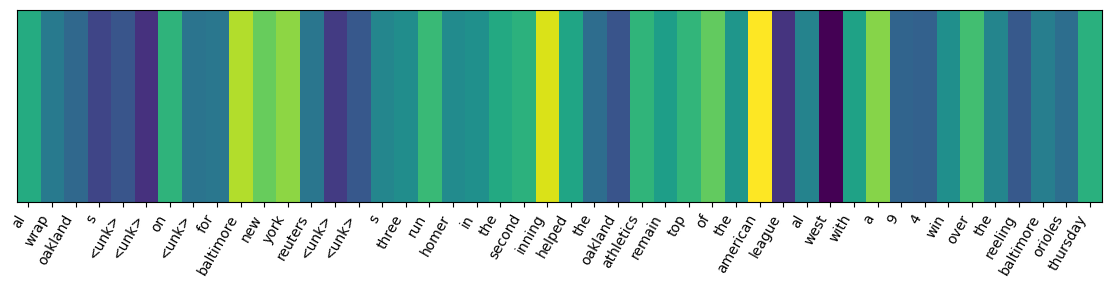

Новость: HP brand to inject new life into ink The company splashes a new name on the inks to be used in its photo printers.
Класс : 3 



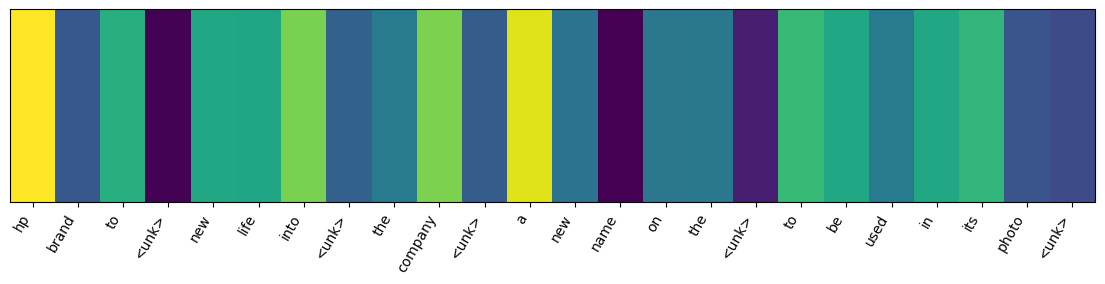

Новость: Language of goals what counts for tongue-tied Ronnie and Michael England striker Michael Owen said his lack of Spanish and Ronaldo #39;s lack of English did not hinder celebrations of the Brazilian #39;s matchwinner for ...
Класс : 1 



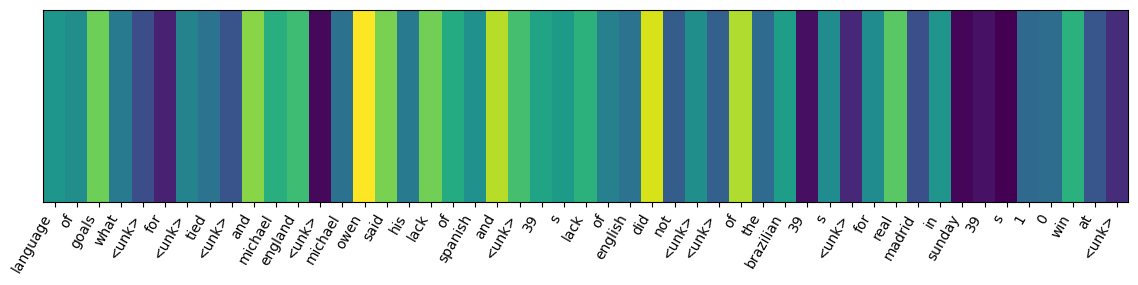

In [34]:
N_EXAMPLES = 3
model.eval()

for idx in random.sample(range(len(RAW_TEST)), N_EXAMPLES):
    sent, label = RAW_TEST[idx]["text"], RAW_TEST[idx]["label"]
    tokens = encode(sent)
    print("Новость:", sent[:220].replace("\n", " ") + ("..." if len(sent) > 220 else ""))
    print("Класс :", label, "\n")

    with torch.no_grad():
        t = torch.tensor(tokens + [0] * (MAX_LEN - len(tokens))).unsqueeze(0).to(device)
        _, gates = model(t, return_gates=True)

    g = gates.squeeze(0)
    importance = g.mean(-1)[:len(tokens)].cpu()

    plt.figure(figsize=(min(14, 0.6 * len(tokens)), 2.5))
    plt.imshow(importance.unsqueeze(0), aspect="auto")
    plt.yticks([])
    plt.xticks(range(len(tokens)),
               [itos[t] for t in tokens], rotation=60, ha="right")
    plt.show()

Проанализируем отдельно каждую из 3х новостей.
1) 1ая новость о спорте. Класс определен верно. Модель наиболее важными посчитала слова oakland, reuters, three, run, homer, athletics, american, league, west. Получается, что география клуба, названия команды/лиги и всякие спортивные термины («homer», «run») — как раз то, что отличает спортивную новость от бизнес-или tech-содержаний. Служебные слова почти глушатся.
2) 2ая новость про науку/технологии/гаджеты. Класс тоже определен верно. Здесь наиболее важными словами были hp, brand, ink, company, photo, printers.
3) 3я новость - снова спорт. Класс верный. Карта подчёркивает фамилии двух нападающих, страны/клубы и слово-маркер «goals». Несмотря на необычную формулировку, модель ловит спортивные сущности, но оставляет низкие веса на частицах (of, and, did).